In [45]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Модель на данных

### Модель:
$$
y = c \cdot \rho^{\beta_1} \cdot d^{\beta_2} \cdot v_1^{\beta_3} \cdot v_2^{\beta_4}
$$

### После логарифмирования:
$$
\ln(y) = \ln(c) + \beta_1 \ln(\rho) + \beta_2 \ln(d) + \beta_3 \ln(v_1) + \beta_4 \ln(v_2)
$$


In [46]:
# Пример данных
data = {
    'rho': [1.2, 0.8, 1.0, 1.1],  # Плотность
    'd': [0.1, 0.15, 0.2, 0.12],  # Диаметр шара
    'v1': [10, 12, 15, 20],       # Горизонтальная компонента скорости
    'v2': [5, 6, 7, 8],           # Вертикальная компонента скорости
    'distance': [20, 35, 50, 60]  # Дальность броска
}
df = pd.DataFrame(data)

# Логарифмирование переменных
df_log = np.log(df[['rho', 'd', 'v1', 'v2']])
df_log['log_distance'] = np.log(df['distance'])

# Обучение модели
X = df_log[['rho', 'd', 'v1', 'v2']]
y = df_log['log_distance']

model = LinearRegression()
model.fit(X, y)

# Вывод коэффициентов
print("Коэффициенты (β):", model.coef_)
print("Константа (ln(c)):", model.intercept_)

# Оценка модели
y_pred = model.predict(X)
mse = mean_squared_error(y, y_pred)
print("Среднеквадратичная ошибка:", mse)

# Новые данные
new_data = pd.DataFrame({
    'rho': [1.0],  # Плотность
    'd': [0.1],    # Диаметр
    'v1': [14],    # Горизонтальная скорость
    'v2': [6]      # Вертикальная скорость
})

# Логарифмирование новых данных
new_data_log = np.log(new_data)

# Предсказание
predicted_log_distance = model.predict(new_data_log)
predicted_distance = np.exp(predicted_log_distance)
print("Предсказанная дальность:", predicted_distance)


Коэффициенты (β): [-0.10889039  0.09097498 -0.72225035  3.34715859]
Константа (ln(c)): -0.4989380647824433
Среднеквадратичная ошибка: 9.860761315262648e-32
Предсказанная дальность: [29.45392893]


# Модель с физическими законами

Дальность броска: 19.66 м


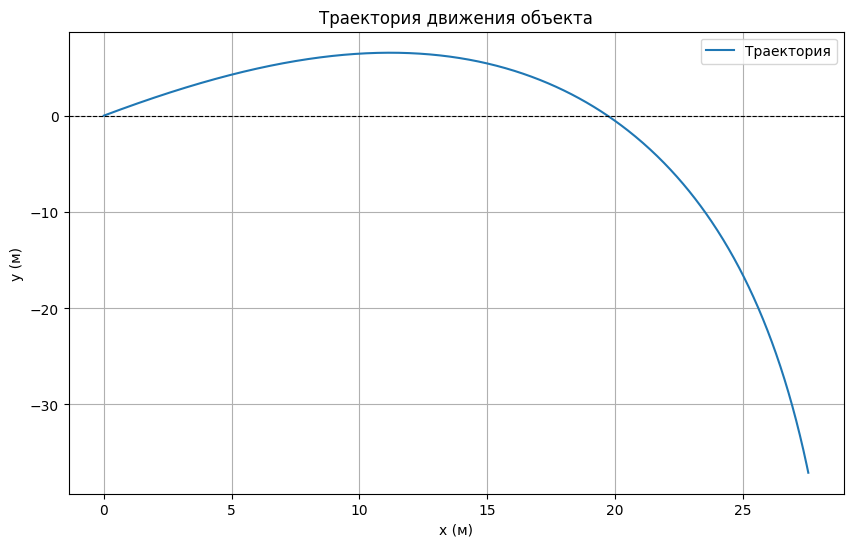

In [47]:
# Физические параметры
g = 9.81  # Ускорение свободного падения (м/с^2)
C_d = 0.1  # Коэффициент сопротивления воздуха
m = 1.0    # Масса объекта (кг)

# Начальные условия
v0 = 20.0  # Начальная скорость (м/с)
theta = np.radians(45)  # Угол броска (в радианах)
x0, y0 = 0, 0  # Начальные координаты (м)
v_x0 = v0 * np.cos(theta)  # Начальная горизонтальная скорость
v_y0 = v0 * np.sin(theta)  # Начальная вертикальная скорость
rho = 100
d = 0.1

# Уравнения движения
def equations(t, state):
    x, y, v_x, v_y = state
    v = np.sqrt(v_x**2 + v_y**2)
    dxdt = v_x
    dydt = v_y
    dv_xdt = - (C_d*rho*v* v_x*np.pi*d*d / m/8) 
    dv_ydt = - (C_d*rho*v* v_y*np.pi*d*d / m/8) - g
    return [dxdt, dydt, dv_xdt, dv_ydt]

# Решение системы уравнений
t_span = (0, 5)  # Время моделирования (секунды)
initial_conditions = [x0, y0, v_x0, v_y0]

solution = solve_ivp(equations, t_span, initial_conditions, max_step=0.01)

# Извлекаем данные
x, y = solution.y[0], solution.y[1]

# Находим дальность (x при y=0)
ground_idx = np.where(y >= 0)[0][-1]
range_x = x[ground_idx]

# Вывод результатов
print(f"Дальность броска: {range_x:.2f} м")

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(x, y, label="Траектория")
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.xlabel("x (м)")
plt.ylabel("y (м)")
plt.title("Траектория движения объекта")
plt.legend()
plt.grid()
plt.show()


#### Поиск параметра

In [48]:
# Физические параметры
g = 9.81  # Ускорение свободного падения (м/с^2)
m = 1.0   # Масса объекта (кг)

# Начальные условия
v0 = 20.0  # Начальная скорость (м/с)
theta = np.radians(45)  # Угол броска (в радианах)
x0, y0 = 0, 0  # Начальные координаты (м)
v_x0 = v0 * np.cos(theta)  # Начальная горизонтальная скорость
v_y0 = v0 * np.sin(theta)  # Начальная вертикальная скорость
rho = 100
d = 0.1

# Целевая дальность
x_target = 19.66  # Экспериментальная дальность (м)

# Исправляем функцию equations и расчет дальности
def equations(t, state, C_d):
    x, y, v_x, v_y = state
    v = np.sqrt(v_x**2 + v_y**2)
    dxdt = v_x
    dydt = v_y
    dv_xdt = - (C_d*rho*v* v_x*np.pi*d*d / m/8) 
    dv_ydt = - (C_d*rho*v* v_y*np.pi*d*d / m/8) - g
    return [dxdt, dydt, dv_xdt, dv_ydt]

def calculate_range(C_d):
    t_span = (0, 5)  # Время моделирования (секунды)
    initial_conditions = [x0, y0, v_x0, v_y0]
    solution = solve_ivp(equations, t_span, initial_conditions, args=(C_d[0],), max_step=0.01)
    
    x, y = solution.y[0], solution.y[1]
    ground_idx = np.where(y >= 0)[0][-1]  # Найти индекс последней точки над землей
    range_x = x[ground_idx]
    return range_x

# Функция для минимизации
def objective(C_d):
    range_x = calculate_range(C_d)
    return (range_x - x_target) ** 2


initial_guess = 1.0
# Оптимизация
result = minimize(objective, [initial_guess], bounds=[(0, 2)])

# Оптимальные результаты
optimal_C_d = result.x[0]
optimal_range = calculate_range([optimal_C_d])

print(optimal_C_d, optimal_range, abs(optimal_range - x_target))

print(f"Начальное приближение коэффициента сопротивления: {initial_guess}")
print(f"Оптимальный коэффициент сопротивления: {optimal_C_d}")



0.10005892004620608 19.66000021834646 2.183464609117891e-07
Начальное приближение коэффициента сопротивления: 1.0
Оптимальный коэффициент сопротивления: 0.10005892004620608


#### Генерируем данные

In [ ]:
# Физические параметры
g = 9.81  # Ускорение свободного падения (м/с^2)
C_d = 0.1  # Коэффициент сопротивления воздуха
m = 1.0    # Масса объекта (кг)

# Генерация данных для различных начальных скоростей и углов
velocities = np.linspace(1, 100, 5)  # Начальные скорости от 1 до 100 м/с
angles = np.linspace(0.1, 89, 5)  # Углы от 0 до 90 градусов
rhos = np.linspace(100, 1000, 3)  # Плотность воздуха (кг/м³)
diameters = np.linspace(0.05, 0.5, 3)  # Диаметры объекта (м)
data = []


for rho in rhos:
    for d in diameters:
        # Уравнения движения
        def equations(t, state):
            x, y, v_x, v_y = state
            v = np.sqrt(v_x**2 + v_y**2)
            dxdt = v_x
            dydt = v_y
            dv_xdt = - (C_d*rho*v* v_x*np.pi*d*d / m/8) 
            dv_ydt = - (C_d*rho*v* v_y*np.pi*d*d / m/8) - g
            return [dxdt, dydt, dv_xdt, dv_ydt]

        for v0 in velocities:
            for theta in angles:
        
                theta_rad = np.radians(theta)  # Перевод угла в радианы
                v_x0 = v0 * np.cos(theta_rad)
                v_y0 = v0 * np.sin(theta_rad)
                initial_conditions = [0, 0, v_x0, v_y0]
                t_span = (0, 15)  # Достаточно большое время моделирования
                
                # Решение системы уравнений
                solution = solve_ivp(equations, t_span, initial_conditions, max_step=0.01)
                x, y = solution.y[0], solution.y[1]
                
                # Находим дальность (x при y=0)
                ground_idx = np.where(y >= 0)[0][-1]
                range_x = x[ground_idx]
                
                # Сохраняем результаты
                data.append({
                    'Начальная скорость (м/с)': v0,
                    'Угол (градусы)': theta,
                    'Плотность (кг/м³)': rho,
                    'Диаметр (м)': d,
                    'Дальность (м)': range_x
                })

# Создание DataFrame
df = pd.DataFrame(data)
df


,Начальная скорость (м/с),Угол (градусы),Плотность (кг/м³),Диаметр (м),Дальность (м)
0,1.0,0.100,100.0,0.05,0.000319
1,1.0,22.325,100.0,0.05,0.066036
2,1.0,44.550,100.0,0.05,0.100719
3,1.0,66.775,100.0,0.05,0.071498
4,1.0,89.000,100.0,0.05,0.003513
...,...,...,...,...,...
220,100.0,0.100,1000.0,0.50,0.240126
221,100.0,22.325,1000.0,0.50,0.534173
222,100.0,44.550,1000.0,0.50,0.441222
223,100.0,66.775,1000.0,0.50,0.260559


#### Линейная регрессия на данных

In [54]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

R^2 на тренировочных данных: 0.8664
R^2 на тестовых данных: 0.8760
Среднеквадратичная ошибка на тестовых данных: 200.0305


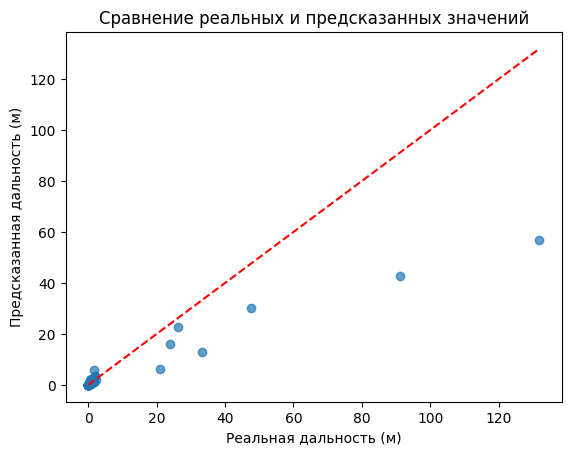

In [55]:
# Вычисляем компоненты скорости
df['v_x0'] = df['Начальная скорость (м/с)'] * np.cos(np.radians(df['Угол (градусы)']))
df['v_y0'] = df['Начальная скорость (м/с)'] * np.sin(np.radians(df['Угол (градусы)']))

# Добавляем логарифмы, избегая деления на ноль
epsilon = 1e-6  # Малое значение для замены нулевых или отрицательных
df_log = df.copy()
df_log['ln(v_x0)'] = np.log(df['v_x0'].replace(0, epsilon))
df_log['ln(v_y0)'] = np.log(df['v_y0'].replace(0, epsilon))
df_log['ln(Плотность)'] = np.log(df['Плотность (кг/м³)'].replace(0, epsilon))
df_log['ln(Диаметр)'] = np.log(df['Диаметр (м)'].replace(0, epsilon))
df_log['ln(Дальность)'] = np.log(df['Дальность (м)'].replace(0, epsilon))

# Убедимся, что больше нет нулевых или отрицательных значений
assert (df_log[['ln(v_x0)', 'ln(v_y0)', 'ln(Плотность)', 'ln(Диаметр)', 'ln(Дальность)']] > -np.inf).all().all()

# Выбор признаков и целевой переменной
X = df_log[['ln(v_x0)', 'ln(v_y0)', 'ln(Плотность)', 'ln(Диаметр)']]
y = df_log['ln(Дальность)']

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели
model = LinearRegression()
model.fit(X_train, y_train)

# Оценка модели
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
mse_test = mean_squared_error(np.exp(y_test), np.exp(y_pred_test))

# Вывод результатов
print(f"R^2 на тренировочных данных: {r2_train:.4f}")
print(f"R^2 на тестовых данных: {r2_test:.4f}")
print(f"Среднеквадратичная ошибка на тестовых данных: {mse_test:.4f}")

# График предсказаний против реальных значений
plt.scatter(np.exp(y_test), np.exp(y_pred_test), alpha=0.7)
plt.plot([min(np.exp(y_test)), max(np.exp(y_test))], 
         [min(np.exp(y_test)), max(np.exp(y_test))], 
         color='red', linestyle='--')
plt.xlabel('Реальная дальность (м)')
plt.ylabel('Предсказанная дальность (м)')
plt.title('Сравнение реальных и предсказанных значений')
plt.show()
